# Multiple Sclerosis Classifier

This notebook contains a simple classifier for multiple sclerosis (MS) based on gene expression data. The goal of this project is to learn how to write a simple classifier for healthy and unhealthy patients.

The data is from a study comparing gene expression in peripheral blood samples between healthy human individuals and patients with relapsing-remitting multiple sclerosis (RRMS). The data was generated using RNA sequencing (RNA-Seq) to identify differences in mRNA levels between the two groups.

If you prefer you can use alternative datasets, classifying different diseases. Data can be acquired [here](https://www.ebi.ac.uk/gxa/experiments?experimentType=%22Differential%22&species=homo+sapiens). 
Choose datasets with at least two experimental factors. 
The default dataset (MS) was from [this](https://www.ebi.ac.uk/gxa/experiments/E-GEOD-66573/Results) link.
In case you are unsure how to handle different datasets, an alternative [dataset](https://www.ebi.ac.uk/gxa/experiments/E-ENAD-46/Results) is included as an example and can be loaded by changing `DATASET = lung` further below.


## Data Files

The data is located in the `data/` folder and consists of two datasets: Multiple Sclerosis (MS) and Lung.

### Multiple Sclerosis (MS)

The MS data is located in the `data/ms/` folder and consists of the following files:

*   `data/ms/raw-counts.tsv`: This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.
*   `data/ms/experiment-design.tsv`: This file describes the samples, indicating which ones are from healthy controls and which are from RRMS patients, along with other relevant metadata.
*   `data/ms/query-results.tsv`: This file contains the query results from the Expression Atlas database.

### Lung

The Lung data is located in the `data/lung/` folder and consists of the following files:

*   `data/lung/raw-counts.tsv`: This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.
*   `data/lung/experiment-design.tsv`: This file describes the samples and their metadata.
*   `data/lung/query-results.tsv`: This file contains the query results from the Expression Atlas database.

### Your Tasks

Your main task is to improve the classifier by selecting better features. This involves the following steps:

1.  **Familiarize yourself with the covariance matrix:** The covariance matrix is a powerful tool for understanding the relationships between features. The current version of this notebook generates a covariance matrix for the first 5 genes.
2.  **Normalization:** The data is normalized before calculating the covariance matrix. Why is this important? What would happen if you didn't normalize the data?
3.  **Feature Selection:** The current version of the notebook only uses the first 5 genes as features. You should experiment with different sets of features to see if you can improve the accuracy of the classifier. You can use the information from the `query results` dataframe to select genes that are differentially expressed between the two groups.
4.  **Interpret the covariance matrix:** What does it mean if a value in the covariance matrix is close to 0? What does it mean if it is close to 1? How can you use this information to select features?
5.  **Implement k-fold cross validation:** Since we have limited data (only 14 samples total), a single train/test split may not give us a reliable estimate of model performance. Implement k-fold cross validation to get a more robust evaluation of your classifier. Consider what value of k would be appropriate given our small dataset size. Compare the results from k-fold cross validation with the simple train/test split approach currently used in the notebook.

In [48]:
# Ensure that packages are installed
!pip install pandas scikit-learn matplotlib numpy

# Import necessary libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Raw Counts

This file contains the raw gene counts for each sample. The rows represent genes and the columns represent samples.

### Select the dataset to use

In [49]:
DATASET = "data" # or "lung"

In [50]:
DATA_DIR = DATASET  #f"data/{DATASET}"

In [51]:
df_raw_counts = pd.read_csv(f"{DATA_DIR}/raw-counts.tsv", sep="\t", index_col=0)
df_raw_counts

,Gene Name,SRR1839796,SRR1839800,SRR1839795,SRR1839804,SRR1839802,SRR1839801,SRR1839803,SRR1839797,SRR1839794,SRR1839792,SRR1839799,SRR1839791,SRR1839798,SRR1839793
Gene ID,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,3,4,3,4,5,3,1,1,0,4,3,8,7,0
ENSG00000000005,TNMD,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,DPM1,81,49,103,96,79,49,74,66,96,22,31,135,70,29
ENSG00000000457,SCYL3,293,193,199,267,211,162,224,156,307,179,104,303,185,47
ENSG00000000460,C1orf112,62,23,23,71,38,51,43,16,38,12,14,46,22,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285990,NBEAP6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000285991,NaN,0,0,0,0,1,0,0,0,0,0,0,4,2,0
ENSG00000285992,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Experiment Design

This file describes the samples, indicating which ones are from healthy controls and which are from RRMS patients, along with other relevant metadata.

In [52]:
df_experiment_design = pd.read_csv(f"{DATA_DIR}/experiment-design.tsv", sep="\t", index_col=0)
df_experiment_design

,Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[ethnic group],Sample Characteristic Ontology Term[ethnic group],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Factor Value[disease],Factor Value Ontology Term[disease],Analysed
Run,,,,,,,,,,,
SRR1839791,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
SRR1839792,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839793,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839794,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
SRR1839795,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839796,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839797,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839798,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Yes
SRR1839799,normal,http://purl.obolibrary.org/obo/PATO_0000461,Caucasian,http://purl.obolibrary.org/obo/HANCESTRO_0005,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,blood,http://purl.obolibrary.org/obo/UBERON_0000178,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes


### Query Results

This file contains the query results from the Expression Atlas database.

In [53]:
df_query_results = pd.read_csv(f"{DATA_DIR}/query-results.tsv", sep="\t", index_col=0)
df_query_results

,Gene Name,'relapsing-remitting multiple sclerosis' vs 'normal' .foldChange,'relapsing-remitting multiple sclerosis' vs 'normal'.pValue
Gene ID,,,
ENSG00000000419,DPM1,0.1,0.686278
ENSG00000000457,SCYL3,0.1,0.750671
ENSG00000000460,C1orf112,-0.4,0.348980
ENSG00000000938,FGR,0.4,0.099978
ENSG00000000971,CFH,-0.4,0.536052
...,...,...,...
ENSG00000285966,ENSG00000285966,0.9,0.070963
ENSG00000285967,NIPBL-DT,-1.0,0.005982
ENSG00000285976,ENSG00000285976,-1.1,0.042264


### Data Preparation

Before we can train a classifier, we need to prepare the data. This involves selecting features and labels from the dataframes.

In [54]:
def get_features_of_patient(df, patient_id):
    """
    Get the raw gene counts of a specific patient from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing patient data.
    patient_id (str): ID of the patient to retrieve features for. You can find the IDs in the first column of the analytics dataframe.
    
    Returns:
    pd.Series: Features of the specified patient.
    """
    return df[patient_id][:1000].to_list() # TODO: Select features smartly, not just the first 5 (genes)

get_features_of_patient(df_raw_counts, "SRR1839791")

[8,
 0,
 135,
 303,
 46,
 14749,
 74,
 251,
 336,
 707,
 58,
 774,
 433,
 242,
 1,
 0,
 585,
 9,
 165,
 179,
 0,
 137,
 526,
 1604,
 18,
 88,
 14,
 0,
 599,
 11091,
 1427,
 1304,
 1517,
 14,
 63,
 60,
 90,
 189,
 1084,
 12565,
 9,
 182,
 4015,
 28,
 2,
 1840,
 249,
 724,
 1817,
 972,
 355,
 534,
 770,
 1975,
 682,
 298,
 185,
 0,
 180,
 162,
 321,
 8,
 54,
 0,
 0,
 143,
 65,
 523,
 2875,
 0,
 208,
 562,
 9,
 5530,
 2485,
 1537,
 508,
 0,
 186,
 271,
 45,
 5,
 373,
 288,
 64,
 6,
 323,
 993,
 2307,
 17,
 590,
 1822,
 6909,
 880,
 251,
 0,
 131,
 178,
 155,
 20,
 2860,
 901,
 81,
 380,
 154,
 2052,
 1073,
 10761,
 237,
 103,
 785,
 6022,
 647,
 0,
 1140,
 801,
 14,
 553,
 1,
 1,
 0,
 1323,
 0,
 0,
 8,
 3054,
 0,
 575,
 0,
 472,
 0,
 74,
 0,
 115,
 332,
 27,
 2131,
 1,
 541,
 1292,
 292,
 436,
 0,
 227,
 0,
 43,
 118,
 51,
 1572,
 0,
 195,
 3,
 937,
 915,
 15,
 798,
 9,
 407,
 41,
 0,
 1152,
 7,
 2,
 37,
 581,
 6,
 406,
 349,
 2448,
 2,
 2,
 2242,
 0,
 2565,
 232,
 890,
 2,
 716,
 4,
 63,

In [55]:
def get_dataset(df_raw_counts, df_experiment_design): 
    """
    Get the entire dataset of features and labels.
    
    Parameters:
    df_raw_counts (pd.DataFrame): DataFrame containing raw gene counts.
    df_experiment_design (pd.DataFrame): DataFrame containing experiment design data.
    
    Returns:
    tuple: Features and labels for the dataset.
    """
    patient_ids = df_experiment_design.index.to_list()
    features = [get_features_of_patient(df_raw_counts, patient_id) for patient_id in patient_ids]
    labels = df_experiment_design["Sample Characteristic[disease]"].to_list()
    unique_labels = list(set(labels))
    labels = [unique_labels.index(label) for label in labels] # Convert labels to numbers
    return features, labels

features, labels = get_dataset(df_raw_counts, df_experiment_design)

### Train/Test Split

We split the data into a training set and a testing set. The training set is used to train the classifier, and the testing set is used to evaluate its performance. The main bottleneck we have with that project is the lack of enough data. In fact, we have 14 cases in total with 8 and 6 cases respectively. 

In [56]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.5, random_state=2)

### Train the Classifier

We use a simple Decision Tree Classifier to train the model.

In [57]:
classifier = DecisionTreeClassifier(random_state=2)
classifier = classifier.fit(train_features, train_labels)

### Evaluate the Classifier

We use the accuracy score to evaluate the performance of the classifier.

In [58]:
predicted_test_labels = classifier.predict(test_features)

In [59]:
accuracy = accuracy_score(test_labels, predicted_test_labels)

print(f"Baseline accuracy: {accuracy}")

Baseline accuracy: 0.8571428571428571


Covariance matrix plot saved to covariance_matrix.png


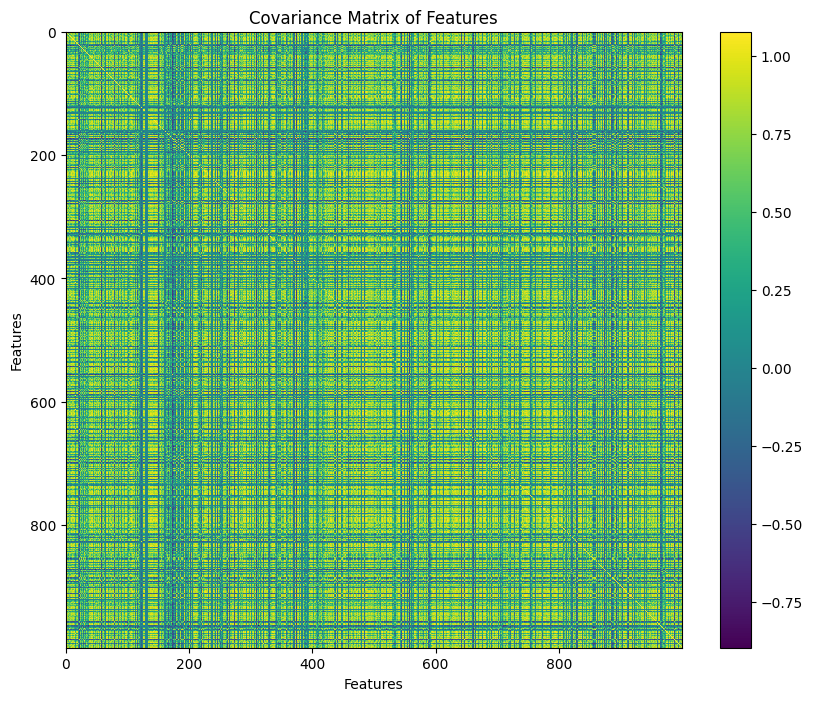

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
data = np.array(features)

# Transpose the data so that rows are samples and columns are features (genes)
data = data

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Calculate the covariance matrix
covariance_matrix = np.cov(data_normalized, rowvar=False)

# Plot the covariance matrix
plt.figure(figsize=(10, 8))
plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest')
plt.title('Covariance Matrix of Features')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Features')
plt.savefig('covariance_matrix.png')
print("Covariance matrix plot saved to covariance_matrix.png")

In [61]:
def get_single_gene_feature(df_raw_counts, df_experiment_design, gene): 
    """
    Get the single gene feature for all patients in the dataset.
    
    Parameters:
    df_raw_counts (pd.DataFrame): DataFrame containing raw gene counts.
    df_experiment_design (pd.DataFrame): DataFrame containing experiment design data.
    
    Returns:
    tuple: Features and labels for the dataset.
    """
    patient_ids = df_experiment_design.index.to_list()

    gene_index = df_raw_counts.index.get_loc(gene)

    features = [df_raw_counts[patient_id][gene_index:gene_index + 1].to_list() for patient_id in patient_ids]
    labels = df_experiment_design["Sample Characteristic[disease]"].to_list()
    unique_labels = list(set(labels))
    labels = [unique_labels.index(label) for label in labels] # Convert labels to numbers
    return features, labels

single_feature, labels = get_single_gene_feature(df_raw_counts, df_experiment_design, "ENSG00000250696")

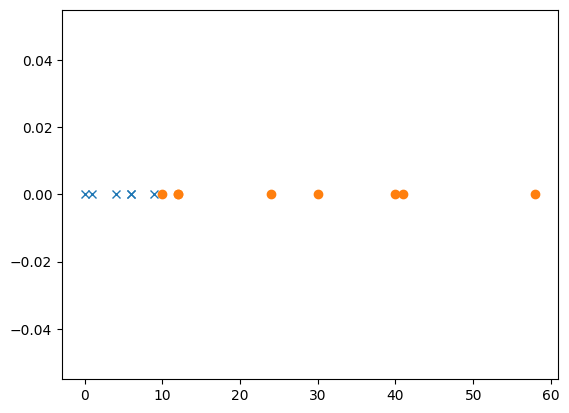

In [62]:
if DATASET == "ms":
    positive_label = "relapsing-remitting multiple sclerosis"
    negative_label = "normal"
else: 
    positive_label = "NHBE"
    negative_label = "A549"

X = np.array(single_feature)[:, 0]
y = np.array(labels)

pos = X[y == 1]
neg = X[y == 0]

plt.plot(pos, np.zeros_like(pos), 'x')
plt.plot(neg, np.zeros_like(neg), 'o')
plt.show()

#TODO: Add 2D plots as well